In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier

In [126]:
def loss_accuracy_graphs(history):
    train_loss = history.history["loss"]
    train_accuracy= history.history["accuracy"]
    test_loss= history.history["val_loss"]
    test_accuracy = history.history["val_accuracy"]
    
    plt.plot(test_loss,label = "test_loss")
    plt.plot(train_loss,label ="train_loss")
    plt.xlabel('epoch')
    plt.ylabel('Loss')  
    plt.title('Train vs Test loss')
    plt.legend()
    plt.show()


    plt.plot(train_accuracy,label = "train_accuracy")
    plt.plot(test_accuracy,label ="test_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('Loss')  
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.show()

                    
def print_logs(history,activation_function,lr,epoch,num_hidden_layers):
    train_loss = history.history["loss"]
    train_accuracy= history.history["accuracy"]
    test_loss= history.history["val_loss"]
    test_accuracy = history.history["val_accuracy"]
    
    print("activation_function ",activation_function ," lr ",lr," epoch ",epoch, " num_hidden_layers ",num_hidden_layers)
    print("train_loss ",train_loss[-1]," train_accuracy ",train_accuracy[-1]," test_loss ",test_loss[-1], " test_accuracy ",test_accuracy[-1])
    
    
def confusion_matrix(X_test,Y_test,model):
    pred = model.predict(X_test.to_numpy(copy=True))
    pred = np.round(pred).astype(int).reshape(1,-1)[0]

    from sklearn.metrics import confusion_matrix
    m = confusion_matrix(pred,Y_test)
    tn, fn, fp, tp=confusion_matrix(pred,Y_test).ravel()
    m=pd.crosstab(pred,Y_test)

    print("Confusion matrix")
    print(m)

def graphs(losses):
    fig, axs = plt.subplots(2,figsize=(25,25))
    fig.suptitle(f'epoch:{losses[0]["epoch"]}')

    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('Loss')  
    axs[0].set_title('Train vs Test loss')

    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('Loss')  
    axs[1].set_title('Train vs Test Accuracy')
    axs[1].legend()

    for loss in losses:
        
        axs[0].plot(loss['train_loss'],label =f'{loss["activation_function"]},lr:{loss["learning_rate"]},E:{loss["epoch"]},layers:{loss["num_hidden_layers"]} train_loss')
        axs[0].plot(loss['test_loss'],label = f'{loss["activation_function"]},lr:{loss["learning_rate"]},E:{loss["epoch"]},layers:{loss["num_hidden_layers"]} test_loss')

        axs[1].plot(loss['train_accuracy'],label = f'{loss["activation_function"]},lr:{loss["learning_rate"]},E:{loss["epoch"]},layers:{loss["num_hidden_layers"]} train_accuracy')
        axs[1].plot(loss['test_accuracy'],label =f'{loss["activation_function"]},lr:{loss["learning_rate"]},E:{loss["epoch"]},layers:{loss["num_hidden_layers"]} test_accuracy')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [127]:
def normalize(data):
    for col in data.columns:
        data[col] = (data[col] - data[col].mean()) / data[col].std()
        data[col] = np.exp(-(data[col] - data[col].mean()) ** 2 / (2 * (data[col].std()) ** 2))
    return data


def split_data(df):
    X = df[["Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion","Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli","Mitoses"]]
    X = normalize(X)
    Y = df["Class"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
    return X_train, X_test, Y_train, Y_test
           

def get_data(dataFile):
        raw_input = pd.read_csv(dataFile,names=["Sample code number","Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion","Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli","Mitoses","Class"])

        del raw_input["Sample code number"]
        raw_input = raw_input.drop(raw_input[raw_input["Bare Nuclei"] == "?"].index)
        raw_input = raw_input.astype(dtype={"Bare Nuclei":"int64"})
        
        raw_input = raw_input.reset_index()
        del raw_input["index"]
        
        raw_input["Class"][raw_input["Class"] == 4] = 1
        raw_input["Class"][raw_input["Class"] == 2] = 0
        
        print("shape ",raw_input.shape)
        #print(raw_input.describe())
        
        return raw_input
    

def data_processing():
    #raw_input = get_data("breast-cancer-wisconsin.csv")
    raw_input = get_data("https://drive.google.com/uc?id=1SSZEE1lEQnN2JpMcnQooCdjDdMYhhFIQ")
    X_train, X_test, Y_train, Y_test = split_data(raw_input) 
    train_evaluate(X_train, Y_train, X_test, Y_test)


In [131]:
def train_evaluate(X_train, Y_train, X_test, Y_test):
    activations = ['sigmoid', 'tanh', 'relu']
    learning_rate = [0.01, 0.1]
    max_iterations = [100, 200]
    num_hidden_layers = [2, 3]

    losses = []
    subplot_losses = []
    
    for epoch in max_iterations:
        for activation_function in activations:
            for lr in learning_rate:
                
                history,model = model_train(X_train, Y_train, X_test, Y_test, learning_rate = 0.1, activation_function = activation_function, epochs = epoch, hidden_layers = num_hidden_layers[0])

                loss = {
                    "epoch":epoch,
                    "activation_function": activation_function,
                    "learning_rate": lr,
                    "num_hidden_layers":num_hidden_layers[0],
                    "train_loss" : history.history["loss"],
                    "train_accuracy" : history.history["accuracy"],
                    "test_loss" : history.history["val_loss"],
                    "test_accuracy" : history.history["val_accuracy"]
                }
                losses.append(loss.copy())
                subplot_losses.append(loss.copy())
                
                print_logs(history,activation_function,lr,epoch,num_hidden_layers[0])
                confusion_matrix(X_test,Y_test,model)
                
                history,model = model_train(X_train, Y_train, X_test, Y_test, learning_rate = 0.1, activation_function = activation_function, epochs = epoch, hidden_layers = num_hidden_layers[1])
                loss = {
                    "epoch":epoch,
                    "activation_function": activation_function,
                    "learning_rate": lr,
                    "num_hidden_layers":num_hidden_layers[0],
                    "train_loss" : history.history["loss"],
                    "train_accuracy" : history.history["accuracy"],
                    "test_loss" : history.history["val_loss"],
                    "test_accuracy" : history.history["val_accuracy"]
                }
                losses.append(loss.copy())
                subplot_losses.append(loss.copy())
                
                print_logs(history,activation_function,lr,epoch,num_hidden_layers[1])
                confusion_matrix(X_test,Y_test,model)
                
                #break
            subplot_losses = losses.copy() 
            graphs(subplot_losses) 
            subplot_losses = []
            #break
#         graphs(losses)
        losses = []       

In [129]:
def model_train(X_train, Y_train, X_test, Y_test, learning_rate = 0.1, activation_function = "sigmoid", epochs = 200, hidden_layers = 2, loss_function = "binary_crossentropy"):
    
    model = Sequential()
    model.add(Dense(2, input_dim = 9, kernel_initializer ='normal', activation = activation_function))
    #model.add(Dense(3, kernel_initializer ='normal', activation = activation_function))
    for i in range(hidden_layers - 1):
        model.add(Dense(3, kernel_initializer ='normal', activation = activation_function))
        
    model.add(Dense(1, kernel_initializer ='normal', activation = 'sigmoid'))
    model.compile(loss = loss_function, optimizer = SGD(learning_rate=learning_rate), metrics = ['accuracy'])

    history = model.fit(X_train.to_numpy(copy=True), Y_train.to_numpy(copy=True), validation_data = (X_test.to_numpy(copy=True), Y_test.to_numpy(copy=True)), epochs = epochs, batch_size = 5, verbose = 0)
    scores = model.evaluate(X_test.to_numpy(copy=True), Y_test.to_numpy(copy=True),  batch_size=137,verbose=0)        

    print("scores - error ", scores[0]," acc ",scores[1])

    return history,model

shape  (683, 10)


/Users/sravanreddy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sravanreddy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


scores - error  0.20938260853290558  acc  0.93430656
activation_function  sigmoid  lr  0.01  epoch  100  num_hidden_layers  2
train_loss  0.2567415452279123  train_accuracy  0.9194139  test_loss  0.20938262272707736  test_accuracy  0.93430656
Confusion matrix
Class   0   1
row_0        
0      90   9
1       0  38
scores - error  0.6445194482803345  acc  0.6569343
activation_function  sigmoid  lr  0.01  epoch  100  num_hidden_layers  3
train_loss  0.6514596340311316  train_accuracy  0.64835167  test_loss  0.6445194663357561  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.5876699090003967  acc  0.7080292
activation_function  sigmoid  lr  0.1  epoch  100  num_hidden_layers  2
train_loss  0.5977470637896122  train_accuracy  0.64835167  test_loss  0.5876699361922967  test_accuracy  0.7080292
Confusion matrix
Class   0   1
row_0        
0      90  40
1       0   7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.643119752407074  acc  0.6569343
activation_function  sigmoid  lr  0.1  epoch  100  num_hidden_layers  3
train_loss  0.6498358465813019  train_accuracy  0.64835167  test_loss  0.6431197297834131  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47


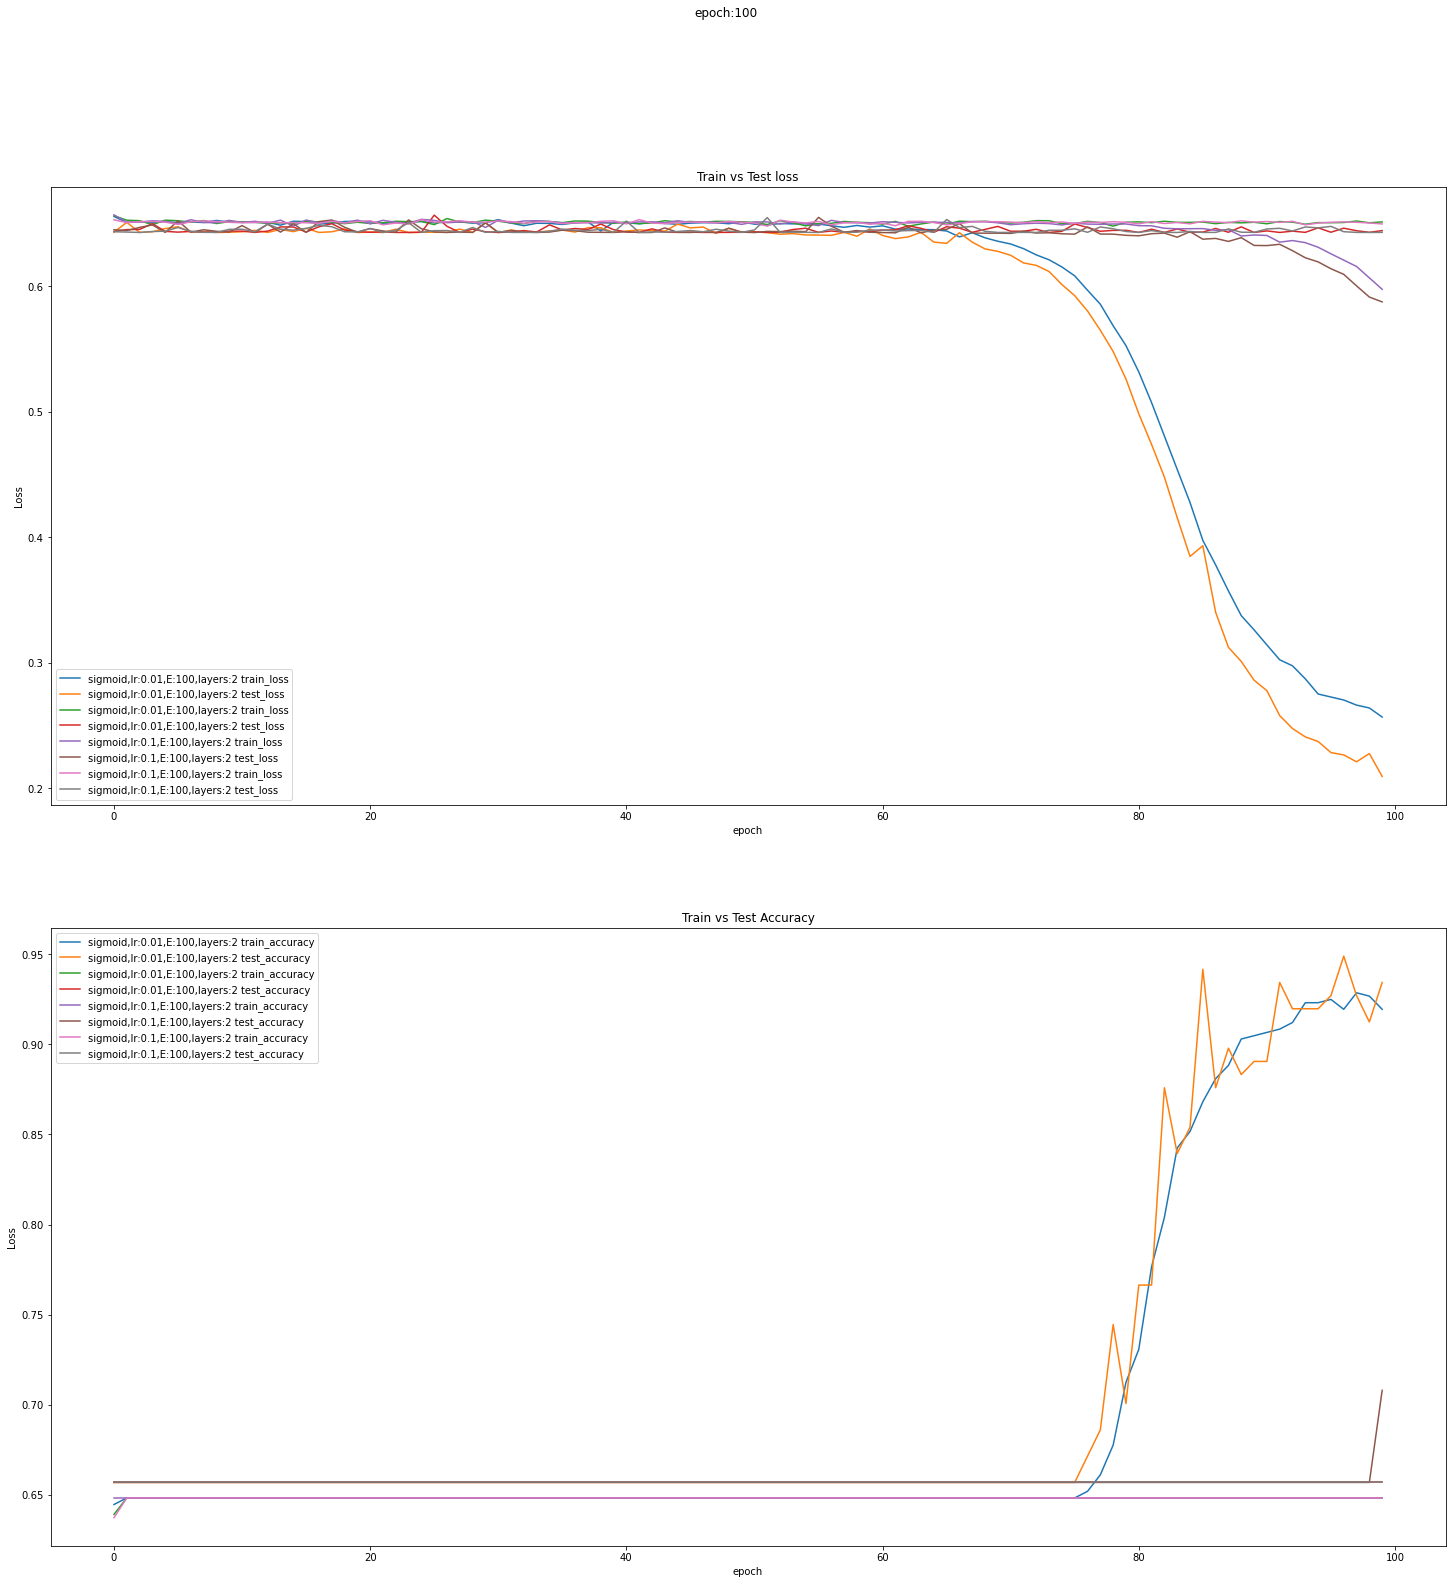

scores - error  0.14486554265022278  acc  0.96350366
activation_function  tanh  lr  0.01  epoch  100  num_hidden_layers  2
train_loss  0.17956110466640074  train_accuracy  0.9542124  test_loss  0.14486552617193138  test_accuracy  0.96350366
Confusion matrix
Class   0   1
row_0        
0      90   5
1       0  42
scores - error  0.6447886228561401  acc  0.6569343
activation_function  tanh  lr  0.01  epoch  100  num_hidden_layers  3
train_loss  0.6498979673935816  train_accuracy  0.64835167  test_loss  0.644788679197757  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.13074903190135956  acc  0.96350366
activation_function  tanh  lr  0.1  epoch  100  num_hidden_layers  2
train_loss  0.17648148926097776  train_accuracy  0.9468864  test_loss  0.13074902953566425  test_accuracy  0.96350366
Confusion matrix
Class   0   1
row_0        
0      89   4
1       1  43


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.6432439088821411  acc  0.6569343
activation_function  tanh  lr  0.1  epoch  100  num_hidden_layers  3
train_loss  0.6505857224647815  train_accuracy  0.64835167  test_loss  0.6432438588490451  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47


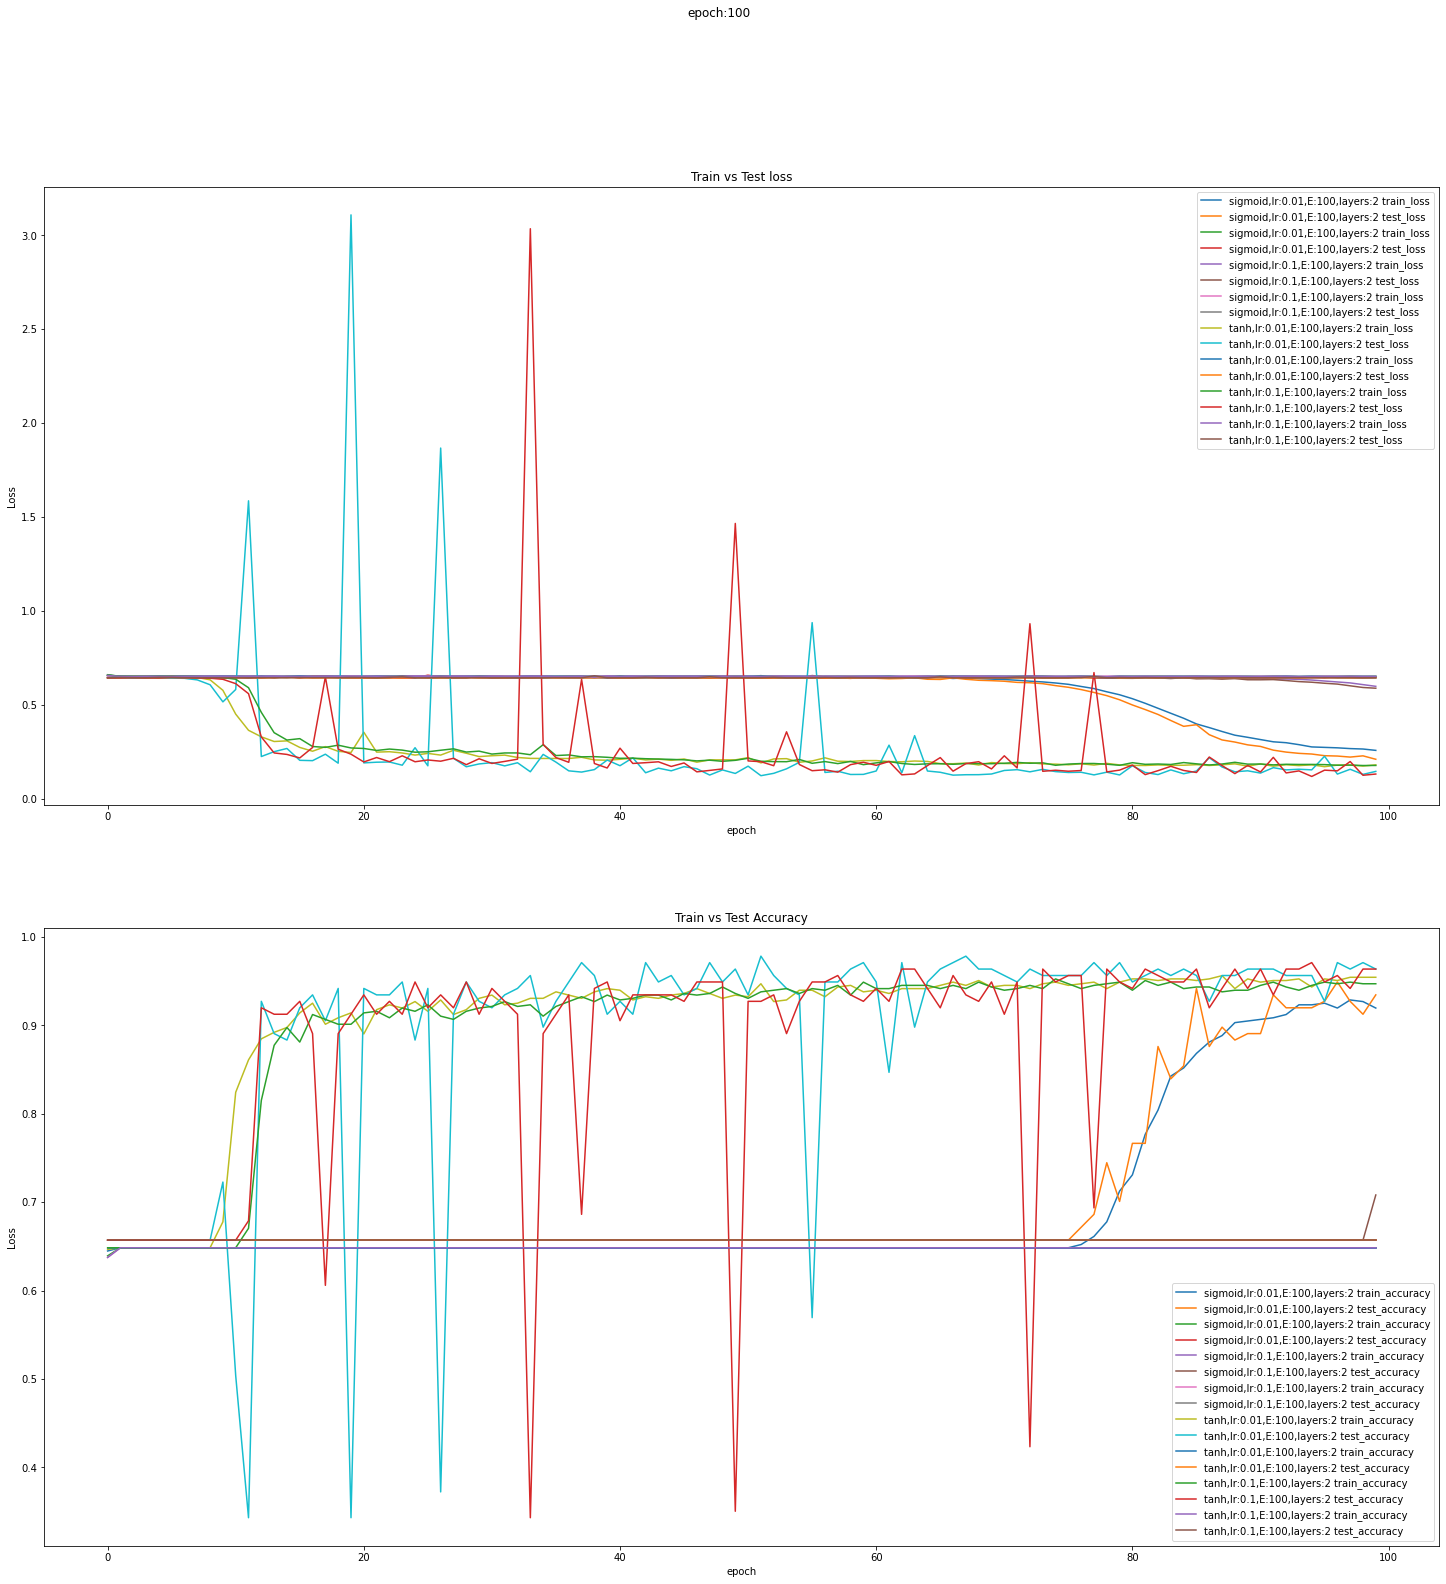

scores - error  0.6434459686279297  acc  0.6569343
activation_function  relu  lr  0.01  epoch  100  num_hidden_layers  2
train_loss  0.6503724396337957  train_accuracy  0.64835167  test_loss  0.6434459048901161  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.6435582637786865  acc  0.6569343
activation_function  relu  lr  0.01  epoch  100  num_hidden_layers  3
train_loss  0.6501086568221067  train_accuracy  0.64835167  test_loss  0.6435582217943929  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.20616266131401062  acc  0.93430656
activation_function  relu  lr  0.1  epoch  100  num_hidden_layers  2
train_loss  0.2867570663307667  train_accuracy  0.9120879  test_loss  0.20616266918606566  test_accuracy  0.93430656
Confusion matrix
Class   0   1
row_0        
0      90   9
1       0  38


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.6435933113098145  acc  0.6569343
activation_function  relu  lr  0.1  epoch  100  num_hidden_layers  3
train_loss  0.6503596690657375  train_accuracy  0.64835167  test_loss  0.6435934105058656  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47


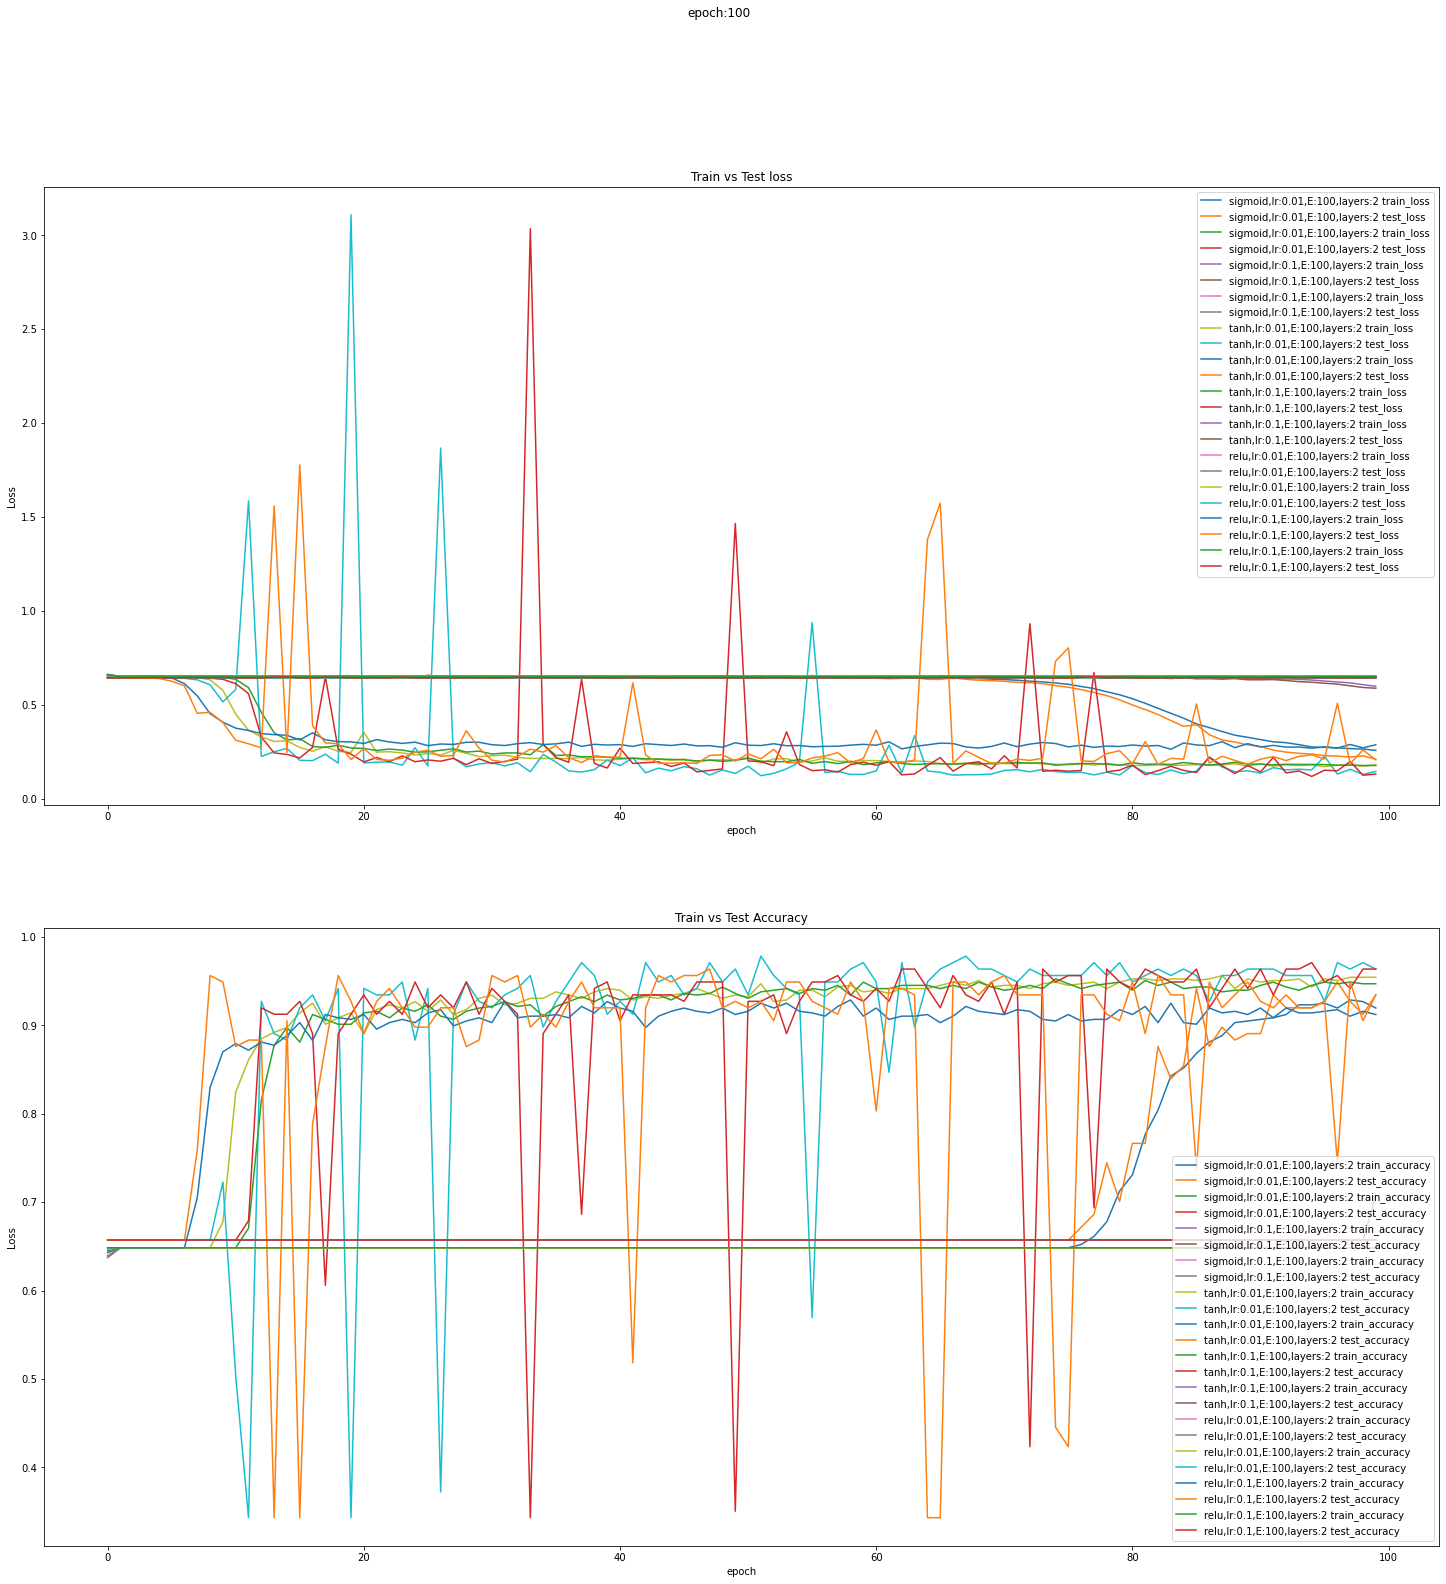

scores - error  0.14228884875774384  acc  0.95620435
activation_function  sigmoid  lr  0.01  epoch  200  num_hidden_layers  2
train_loss  0.1996705122496728  train_accuracy  0.9358974  test_loss  0.14228886059981627  test_accuracy  0.95620435
Confusion matrix
Class   0   1
row_0        
0      90   6
1       0  41
scores - error  0.6443517208099365  acc  0.6569343
activation_function  sigmoid  lr  0.01  epoch  200  num_hidden_layers  3
train_loss  0.6504664168908045  train_accuracy  0.64835167  test_loss  0.6443517282061333  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.2646437883377075  acc  0.90510947
activation_function  sigmoid  lr  0.1  epoch  200  num_hidden_layers  2
train_loss  0.2158080448256635  train_accuracy  0.93040293  test_loss  0.26464380867724874  test_accuracy  0.90510947
Confusion matrix
Class   0   1
row_0        
0      79   2
1      11  45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.6457242369651794  acc  0.6569343
activation_function  sigmoid  lr  0.1  epoch  200  num_hidden_layers  3
train_loss  0.6510533370050319  train_accuracy  0.64835167  test_loss  0.6457241919353931  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47


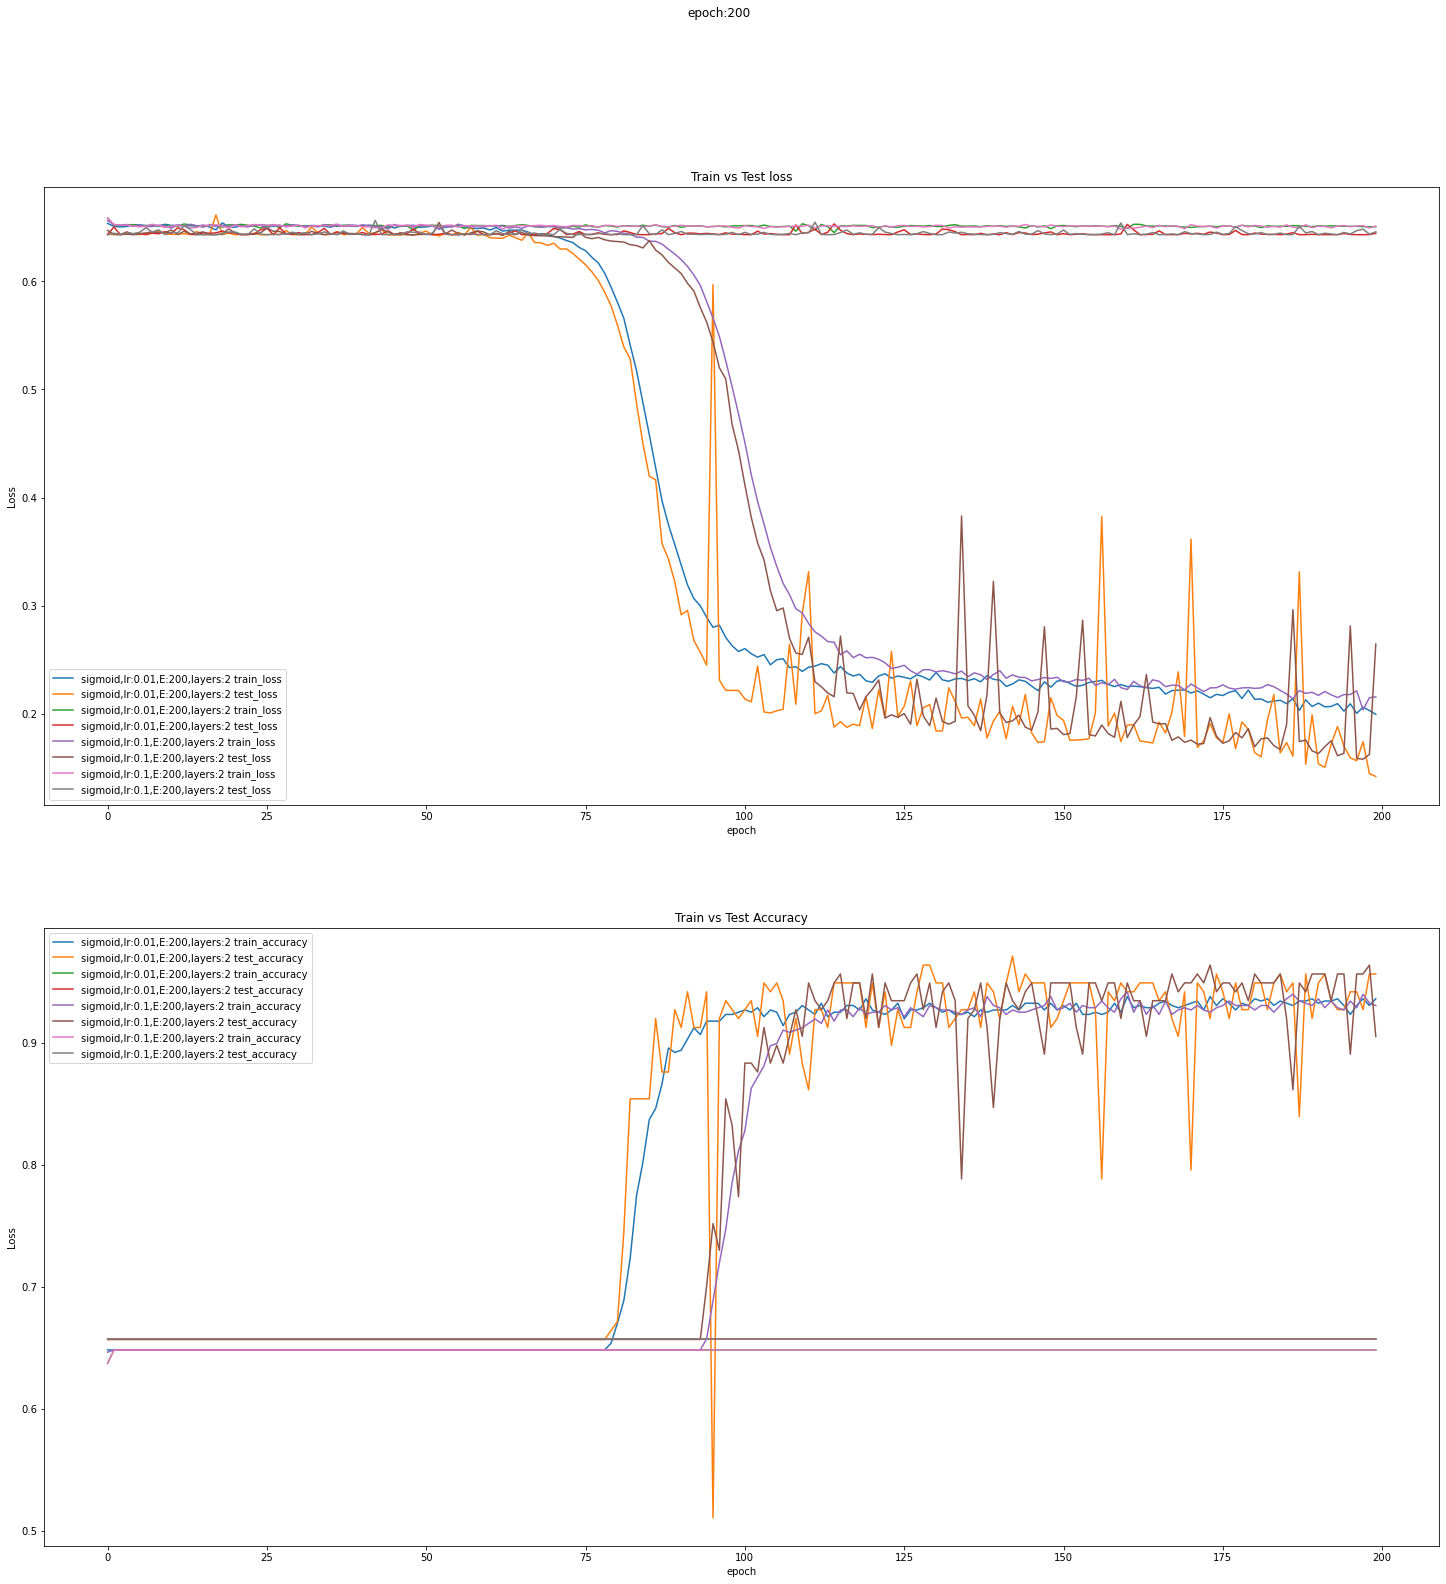

scores - error  0.1423621028661728  acc  0.95620435
activation_function  tanh  lr  0.01  epoch  200  num_hidden_layers  2
train_loss  0.1771747600815972  train_accuracy  0.94871795  test_loss  0.14236208700649713  test_accuracy  0.95620435
Confusion matrix
Class   0   1
row_0        
0      90   6
1       0  41
scores - error  0.6432263851165771  acc  0.6569343
activation_function  tanh  lr  0.01  epoch  200  num_hidden_layers  3
train_loss  0.6510207233302322  train_accuracy  0.64835167  test_loss  0.6432263309503123  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.17467784881591797  acc  0.9489051
activation_function  tanh  lr  0.1  epoch  200  num_hidden_layers  2
train_loss  0.1690024525548021  train_accuracy  0.94871795  test_loss  0.1746778497608365  test_accuracy  0.9489051
Confusion matrix
Class   0   1
row_0        
0      90   7
1       0  40


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.16311995685100555  acc  0.96350366
activation_function  tanh  lr  0.1  epoch  200  num_hidden_layers  3
train_loss  0.19628279845847751  train_accuracy  0.9468864  test_loss  0.1631199575172071  test_accuracy  0.96350366
Confusion matrix
Class   0   1
row_0        
0      90   5
1       0  42


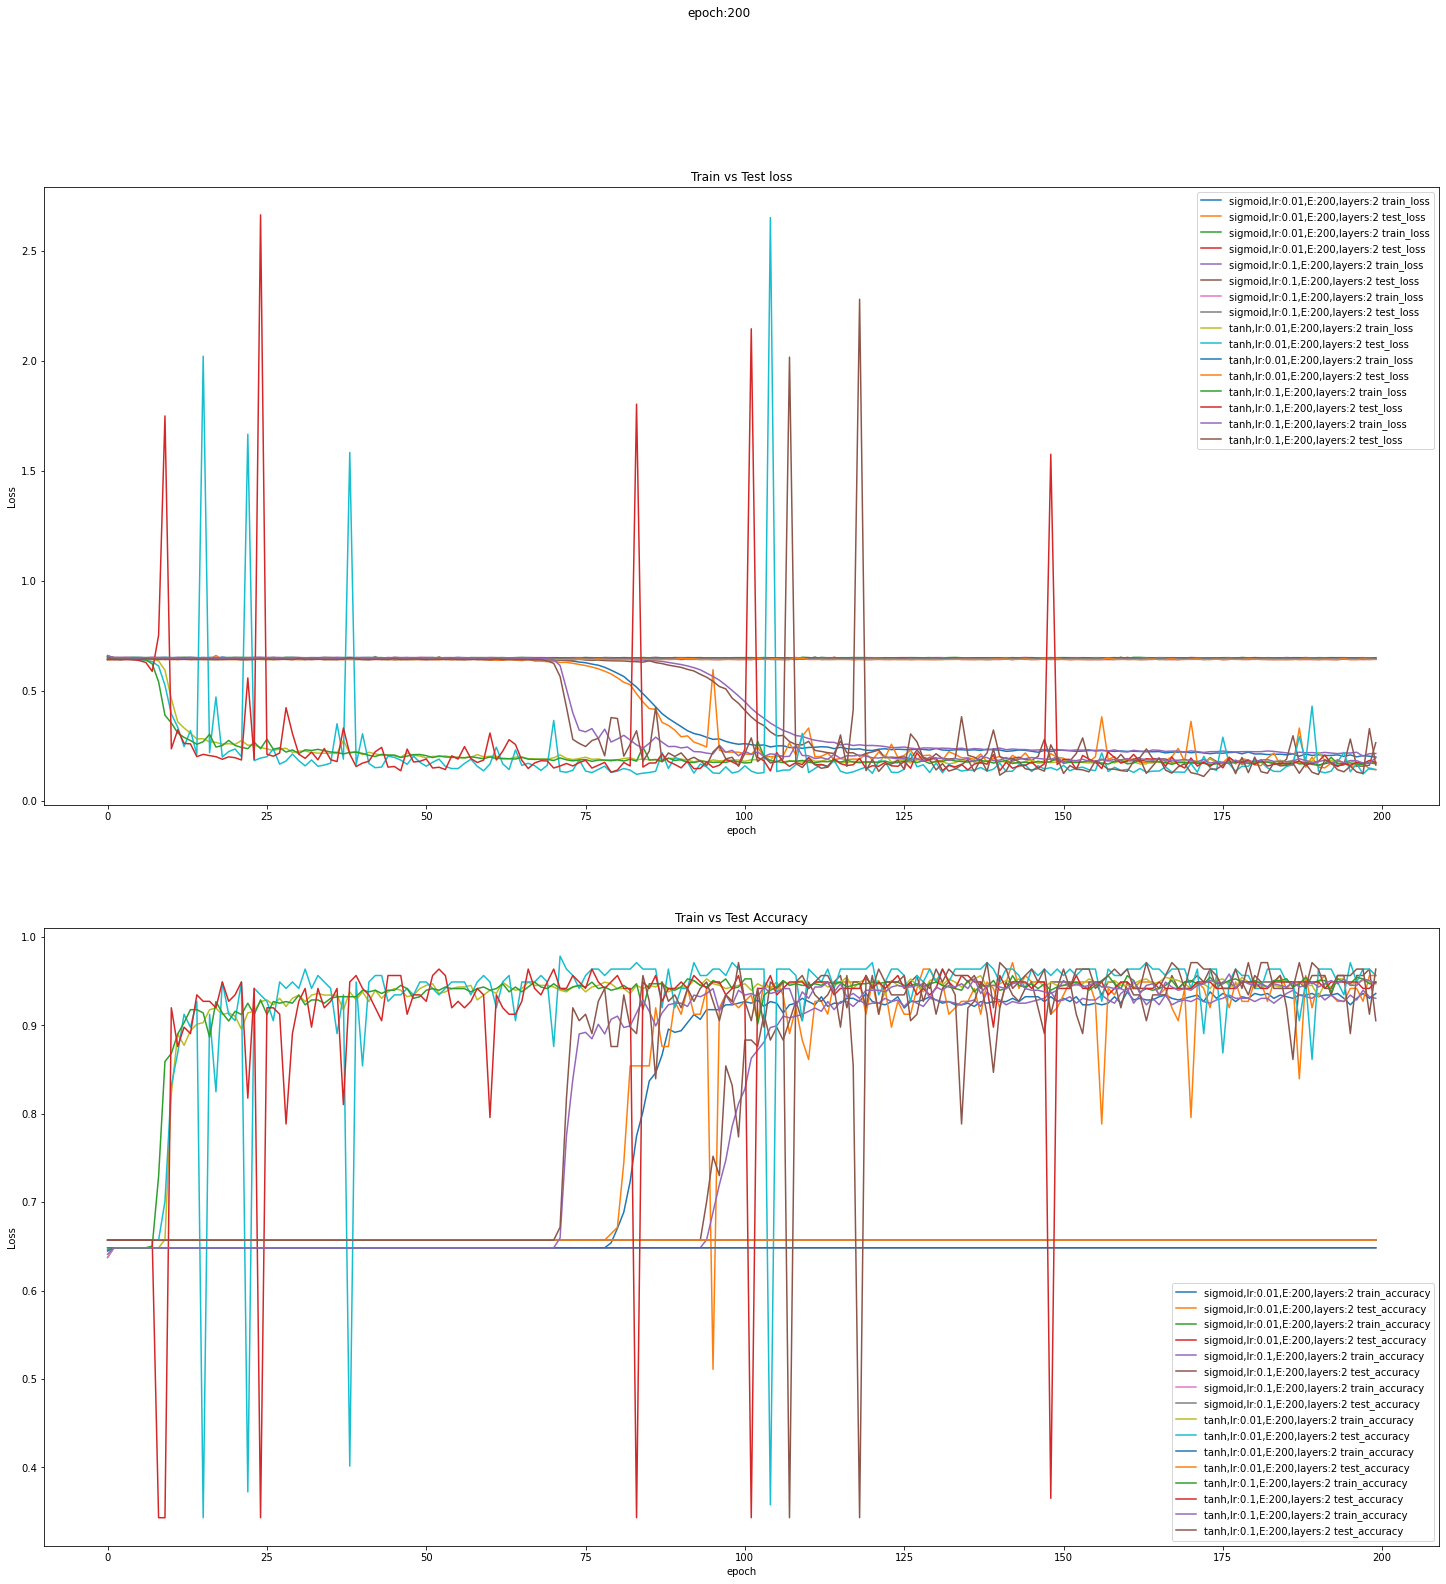

scores - error  0.180039182305336  acc  0.94160587
activation_function  relu  lr  0.01  epoch  200  num_hidden_layers  2
train_loss  0.22325535931064297  train_accuracy  0.9212454  test_loss  0.1800391667855591  test_accuracy  0.94160587
Confusion matrix
Class   0   1
row_0        
0      90   8
1       0  39
scores - error  0.6430653929710388  acc  0.6569343
activation_function  relu  lr  0.01  epoch  200  num_hidden_layers  3
train_loss  0.6503286148820605  train_accuracy  0.64835167  test_loss  0.6430653251000564  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47
scores - error  0.15095959603786469  acc  0.93430656
activation_function  relu  lr  0.1  epoch  200  num_hidden_layers  2
train_loss  0.16937061394919936  train_accuracy  0.94505495  test_loss  0.15095961410688222  test_accuracy  0.93430656
Confusion matrix
Class   0   1
row_0        
0      90   9
1       0  38


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


scores - error  0.6430912613868713  acc  0.6569343
activation_function  relu  lr  0.1  epoch  200  num_hidden_layers  3
train_loss  0.6504092500869171  train_accuracy  0.64835167  test_loss  0.6430912537731394  test_accuracy  0.6569343
Confusion matrix
Class   0   1
row_0        
0      90  47


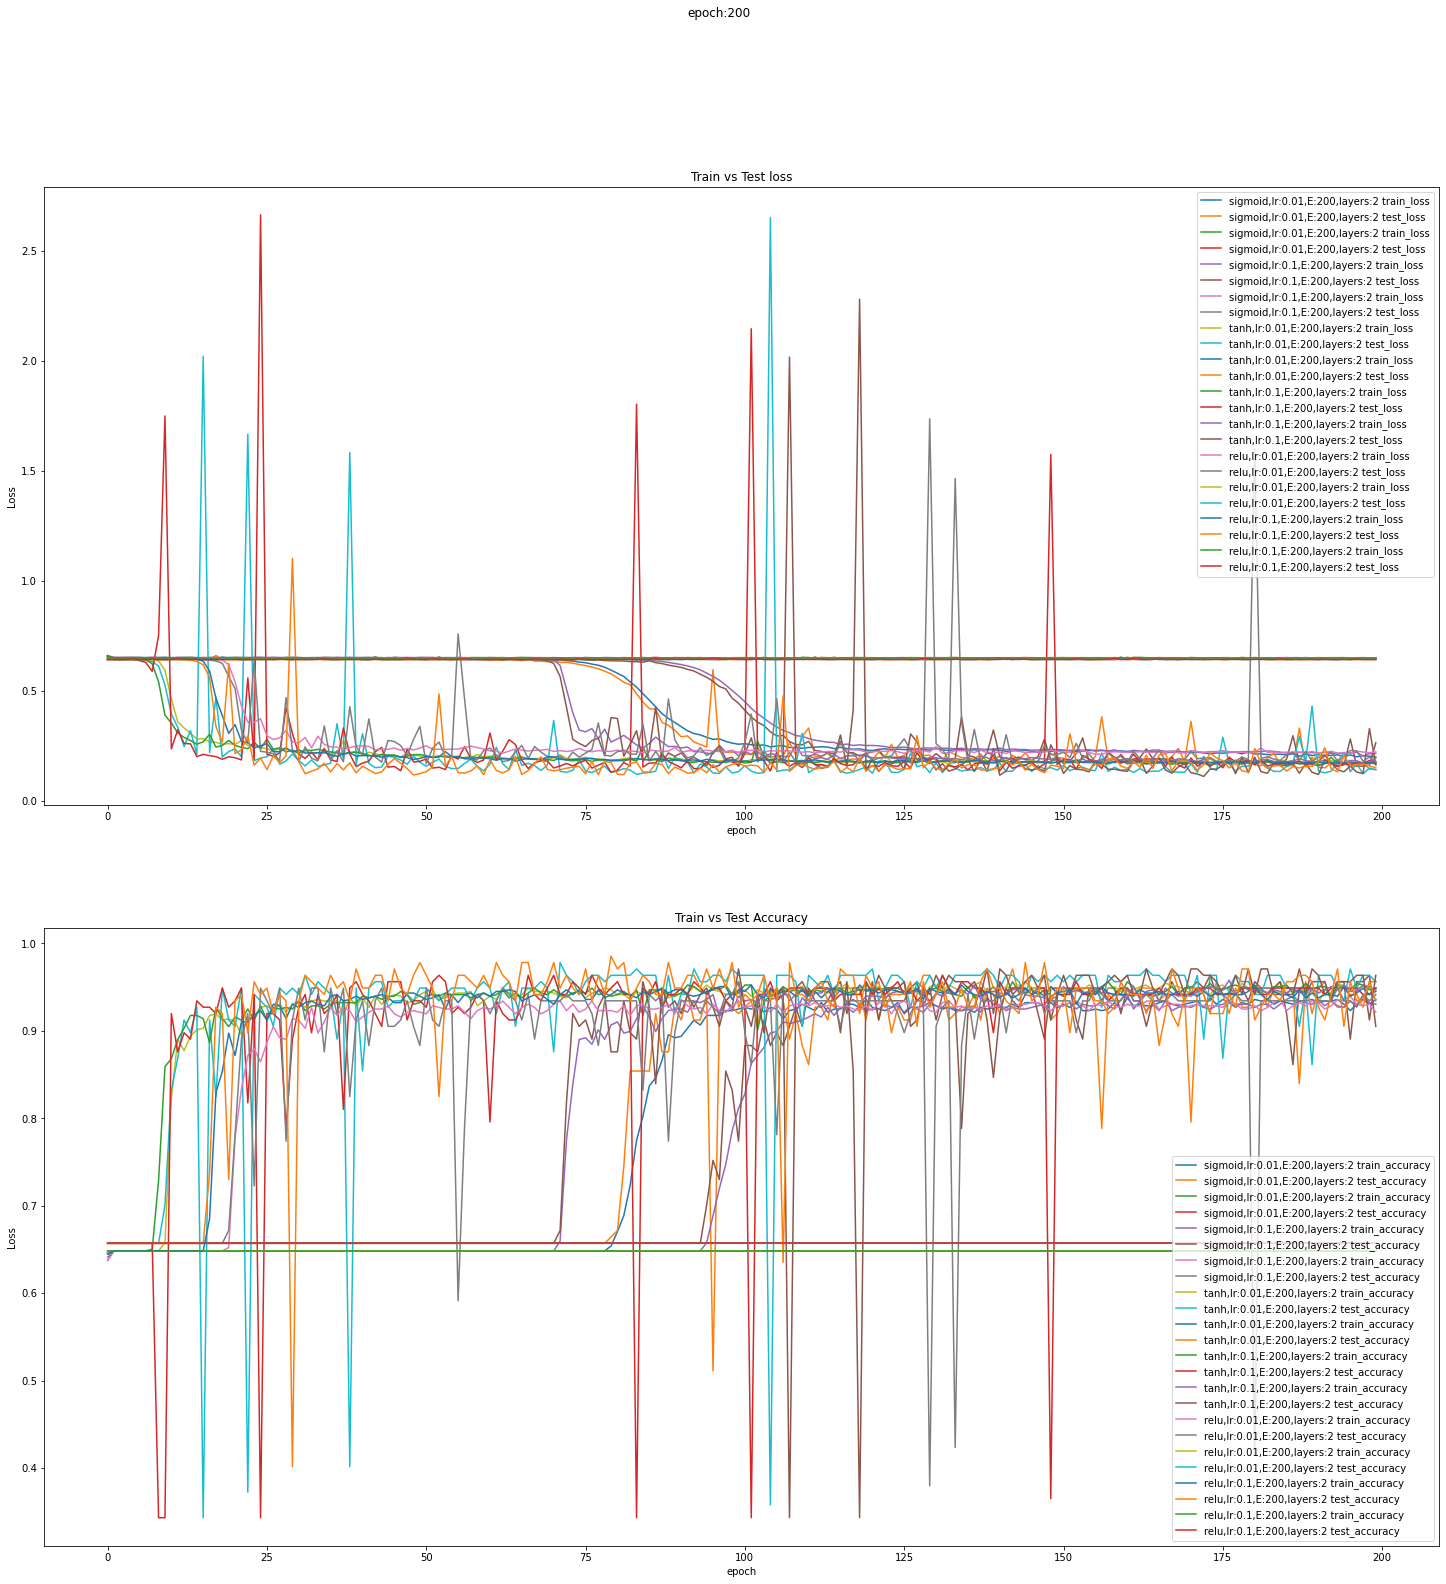

In [132]:
data_processing()